In [4]:
import torch
import os
cwd = os.getcwd()
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

idx_to_class = {0:'Negative', 1:'Positive'}

In [6]:
from torchvision import transforms

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [7]:
base_model = torch.load('./mynet_v1.pt', map_location=torch.device('cpu'))
plt.show()

## Inference

In [8]:
def predict(model, test_image, print_class = False):
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
    
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [9]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            predicted_class = predict(base_model,Image.fromarray(a))
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [10]:
import urllib

def predict_on_crops_by_url(input_image, height=227, width=227):
    req = urllib.request.urlopen(input_image)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    im = cv2.imdecode(arr, -1)

    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)

    print(predict(base_model, Image.fromarray(im)))

    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            predicted_class = predict(base_model,Image.fromarray(a))
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    cv2.imwrite(os.path.join('real_images','predictions',  'result.jpg'), output_image)
    return output_image

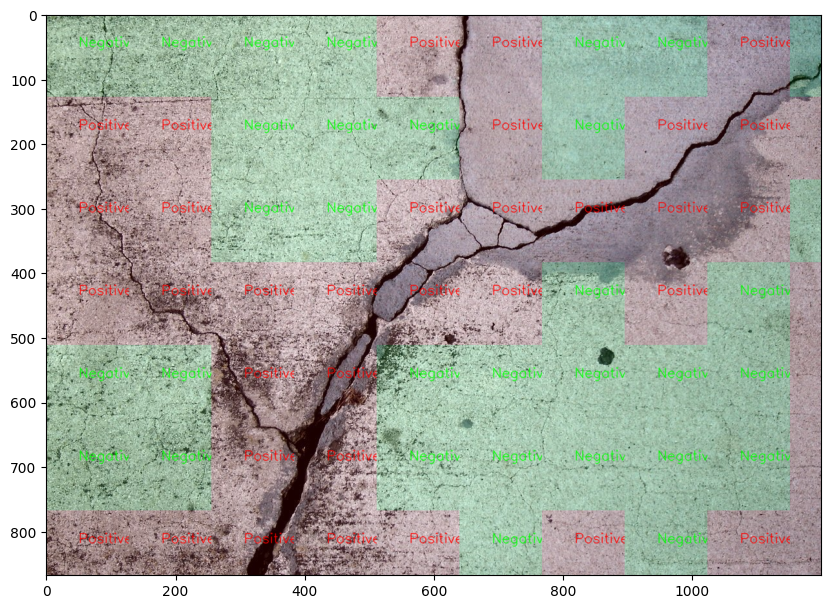

In [11]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/concrete_crack1.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

Negative


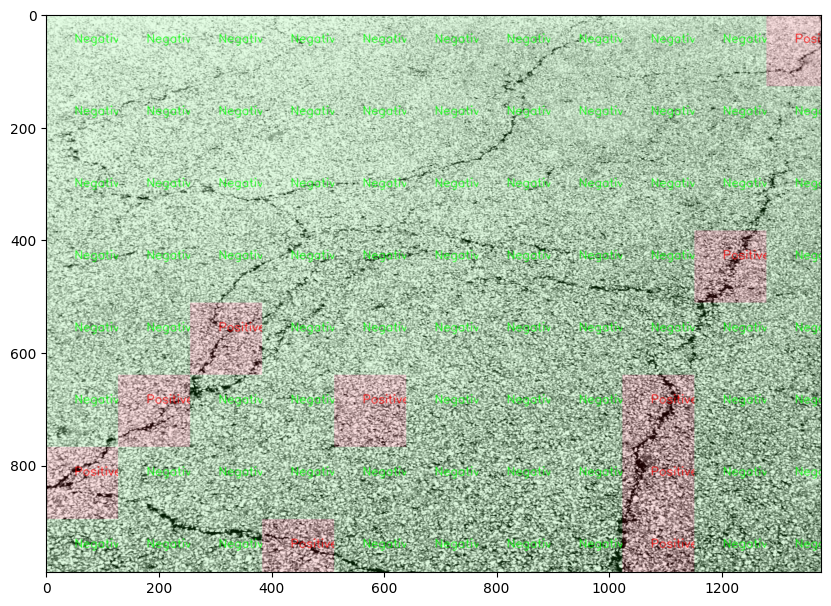

In [12]:
plt.figure(figsize=(10,10))
url = 'https://i.pinimg.com/originals/9e/a9/8c/9ea98c0e9fa3ce5efbd7bccd67e73ea2.jpg'
output_image = predict_on_crops_by_url(url, 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [13]:
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

negative_path = './val/Negative'
positive_path = './val/Positive'

negative_images = os.listdir(negative_path)
positive_images = os.listdir(positive_path)

predicted_labels = []
ground_truth_labels = []

for image in negative_images:
    image_path = os.path.join(negative_path, image)
    predicted_label = predict(base_model, Image.open(image_path))
    predicted_labels.append(predicted_label)
    ground_truth_labels.append('Negative')

for image in positive_images:
    image_path = os.path.join(positive_path, image)
    predicted_label = predict(base_model, Image.open(image_path))
    predicted_labels.append(predicted_label)
    ground_truth_labels.append('Positive')

accuracy = accuracy_score(ground_truth_labels, predicted_labels)
recall = recall_score(ground_truth_labels, predicted_labels, pos_label='Positive')
precision = precision_score(ground_truth_labels, predicted_labels, pos_label='Positive')
f1 = f1_score(ground_truth_labels, predicted_labels, pos_label='Positive')

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1-score:', f1)